the authors developed a web-based AI platform for detecting phishing emails, employing ML models such as Support Vector Machine (SVM), multinomial naive Bayes, and random forest. These models used Term Frequency-Inverse Document Frequency (TF-IDF) for feature extraction.

https://www.sciencedirect.com/science/article/pii/S0045790624005524

## Al-Subaiey et al; 2024 features
1. Used TF-IDF for feature extraction

## Features from Khonji et al; 2012 ##

1.   b_dear = Binaray feature that returns 1 if word "dear" is found in the body of the message , else 0
2.   b_form = Does the message contain HTML form? (binary)
3. b_numwords = Total number of words found in body (cont.)
4. b_numchr = Total number of characters found in body (cont.)
5. b_numunique = A feature that returns the
total number of unique words found in the body a given
email message
6. b_numfunct = A feature that returns
the total number of function words found in the body of
a given email

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import email
from datetime import datetime
from wordcloud import WordCloud
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.ticker as ticker

In [2]:
df_train = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\train_raw.csv')
df_test = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\test_raw.csv')
df_val = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\val_raw.csv')

In [3]:
def extract_features(df):
    # Initialize a dataframe to store features
    features_df = pd.DataFrame()

    # 1. b_dear - Binary feature for "dear" in body
    features_df['b_dear'] = df['Email Text'].apply(
        lambda x: 1 if 'dear' in str(x).lower() else 0
    )

    # 2. b_form - Does the message contain HTML form?
    features_df['b_form'] = df['Email Text'].apply(
        lambda x: 1 if '<form' in str(x).lower() else 0
    )

    # 3. b_numwords - Total number of words in body
    features_df['b_numwords'] = df['Email Text'].apply(
        lambda x: len(str(x).split())
    )

    # 4. b_numchr - Total number of characters in body
    features_df['b_numchr'] = df['Email Text'].apply(
        lambda x: len(str(x))
    )

    # 5. b_numunique - Total number of unique words
    features_df['b_numunique'] = df['Email Text'].apply(
        lambda x: len(set(str(x).lower().split()))
    )

    # 6. b_numfunct - Function words in body
    function_words = {
    "account", "access", "bank", "credit", "click", "identity",
    "inconvenience", "information", "limited", "log", "minutes",
    "password", "recently", "risk", "social", "security",
    "service", "suspended"
    }

    features_df['b_numfunct'] = df['Email Text'].apply(
        lambda x: sum(1 for word in str(x).lower().split() if word in function_words)
    )

    # Add target variable
    if 'Email Type' in df.columns:
        features_df['Email Type'] = df['Email Type']

    # THIS IS THE MISSING LINE
    return features_df

In [4]:
# Extract features for each dataset
train_features = extract_features(df_train)
val_features = extract_features(df_val)
test_features = extract_features(df_test)

# Display feature statistics
print("Training set features shape:", train_features.shape)
print("Validation set features shape:", val_features.shape)
print("Test set features shape:", test_features.shape)

# Display some sample data
print("\nSample of training features:")
print(train_features.head())

# Check for any missing values
print("\nMissing values in training set:")
print(train_features.isnull().sum())

Training set features shape: (13054, 7)
Validation set features shape: (2798, 7)
Test set features shape: (2798, 7)

Sample of training features:
   b_dear  b_form  b_numwords  b_numchr  b_numunique  b_numfunct  \
0       0       0         142       983          107           1   
1       0       0         291      3130          175           1   
2       0       0          42       221           35           0   
3       0       0          44       187           36           0   
4       0       0           6        34            6           0   

       Email Type  
0  Phishing Email  
1      Safe Email  
2      Safe Email  
3      Safe Email  
4  Phishing Email  

Missing values in training set:
b_dear         0
b_form         0
b_numwords     0
b_numchr       0
b_numunique    0
b_numfunct     0
Email Type     0
dtype: int64


In [5]:
# Feature summary and significance

train_features['target'] = train_features['Email Type'].apply(
    lambda x: 1 if x == 'Phishing Email' else 0
)

b_features = ['b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct']

# Corr with phishing emails
b_feature_correlation = []
for feature in b_features:
    corr = train_features[feature].corr(train_features['target'])
    b_feature_correlation.append(corr)

for feature, corr in zip(b_features, b_feature_correlation):
    print(f"{feature}: {corr:.4f}")

b_dear: 0.0851
b_form: nan
b_numwords: -0.0083
b_numchr: -0.0084
b_numunique: -0.0227
b_numfunct: -0.0041


D:\.venv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\.venv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def extract_tfidf_features(df_train, df_test, df_val=None, max_features=100, custom_vocabulary=None):
    """
    Extract TF-IDF features from email text and add them to existing features.

    Parameters:
    -----------
    df_train : DataFrame
        Training dataset with 'Email Text' column
    df_test : DataFrame
        Test dataset with 'Email Text' column
    df_val : DataFrame, optional
        Validation dataset with 'Email Text' column
    max_features : int, default=100
        Maximum number of TF-IDF features to extract
    custom_vocabulary : list, optional
        List of specific terms to use in TF-IDF. If None, uses top max_features terms.

    Returns:
    --------
    tuple of DataFrames
        (train_features, test_features, val_features) with TF-IDF features added
    """
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        lowercase=True,
        vocabulary=custom_vocabulary,
        ngram_range=(1, 2)  # Include unigrams and bigrams
    )

    # Fit and transform on training data
    tfidf_train = tfidf_vectorizer.fit_transform(df_train['Email Text'].astype(str))

    # Transform test data
    tfidf_test = tfidf_vectorizer.transform(df_test['Email Text'].astype(str))

    # Transform validation data if provided
    if df_val is not None:
        tfidf_val = tfidf_vectorizer.transform(df_val['Email Text'].astype(str))

    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Convert TF-IDF matrices to DataFrames
    tfidf_train_df = pd.DataFrame(
        tfidf_train.toarray(),
        columns=[f'tfidf_{term}' for term in feature_names]
    )

    tfidf_test_df = pd.DataFrame(
        tfidf_test.toarray(),
        columns=[f'tfidf_{term}' for term in feature_names]
    )

    if df_val is not None:
        tfidf_val_df = pd.DataFrame(
            tfidf_val.toarray(),
            columns=[f'tfidf_{term}' for term in feature_names]
        )

    # Add original indices
    tfidf_train_df.index = df_train.index
    tfidf_test_df.index = df_test.index
    if df_val is not None:
        tfidf_val_df.index = df_val.index

    # Create return values
    if df_val is not None:
        return tfidf_train_df, tfidf_test_df, tfidf_val_df, feature_names
    else:
        return tfidf_train_df, tfidf_test_df, None, feature_names


# Example usage:
# Define phishing-related terms you want to specifically look for
phishing_vocabulary = [
    # Authentication and account-related
    'account', 'password', 'login', 'verify', 'confirmation', 'security',
    # Action words
    'update', 'confirm', 'validate', 'click', 'secure',
    # Urgency terms
    'urgent', 'immediately', 'alert', 'attention', 'important',
    # Banking and financial
    'bank', 'paypal', 'transaction', 'suspended', 'limited', 'access',
    # Common bigrams in phishing
    'account access', 'verify account', 'update information', 'security alert',
    'unusual activity', 'login attempt', 'confirm identity', 'account suspended',
    'security measure', 'customer service'
]

# Extract TF-IDF features using custom vocabulary
tfidf_train, tfidf_test, tfidf_val, feature_names = extract_tfidf_features(
    df_train,
    df_test,
    df_val,
    max_features=None,  # When using custom vocabulary, set to None
    custom_vocabulary=phishing_vocabulary
)

# Combine with existing features
train_features_with_tfidf = pd.concat([train_features, tfidf_train], axis=1)
test_features_with_tfidf = pd.concat([test_features, tfidf_test], axis=1)
val_features_with_tfidf = pd.concat([val_features, tfidf_val], axis=1)

# Now you can see which TF-IDF features are most correlated with phishing
# First, ensure we have the target column
train_features_with_tfidf['target'] = train_features_with_tfidf['Email Type'].apply(
    lambda x: 1 if x == 'Phishing Email' else 0
)

# Calculate correlation for TF-IDF features
tfidf_correlations = []
for feature in feature_names:
    feature_name = f'tfidf_{feature}'
    corr = train_features_with_tfidf[feature_name].corr(train_features_with_tfidf['target'])
    tfidf_correlations.append((feature, corr))

# Sort by absolute correlation
tfidf_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Print top correlated TF-IDF features
print("Top 5 TF-IDF features by correlation with phishing:")
for term, corr in tfidf_correlations[:5]:
    print(f"TF-IDF_{term}: {corr:.4f}")

Top 5 TF-IDF features by correlation with phishing:
TF-IDF_click: 0.2478
TF-IDF_update: -0.1001
TF-IDF_secure: 0.0866
TF-IDF_security: 0.0856
TF-IDF_bank: 0.0784


In [8]:
# Modify so only the top 5 features are showed plus the original Khonji et a. 2012
# Define the features to keep
selected_features = [
    'tfidf_click', 'tfidf_update', 'tfidf_secure', 'tfidf_security', 'tfidf_bank',
    'b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct'
]

# Keep only the selected features (this will modify the DataFrame in place)
train_features_with_tfidf = train_features_with_tfidf[selected_features]

# test to see it it worked
print(train_features_with_tfidf.head(10))

   tfidf_click  tfidf_update  tfidf_secure  tfidf_security  tfidf_bank  \
0          0.0           0.0           0.0             0.0         0.0   
1          0.0           0.0           0.0             0.0         0.0   
2          0.0           0.0           0.0             0.0         0.0   
3          0.0           0.0           0.0             0.0         0.0   
4          0.0           0.0           0.0             0.0         0.0   
5          1.0           0.0           0.0             0.0         0.0   
6          0.0           0.0           0.0             0.0         0.0   
7          1.0           0.0           0.0             0.0         0.0   
8          0.0           0.0           0.0             0.0         0.0   
9          0.0           0.0           0.0             0.0         0.0   

   b_dear  b_form  b_numwords  b_numchr  b_numunique  b_numfunct  
0       0       0         142       983          107           1  
1       0       0         291      3130          17

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,  # Adjust as needed
    stop_words='english',
    lowercase=True
)

# Extract TF-IDF features from training data
tfidf_train = tfidf_vectorizer.fit_transform(df_train['Email Text'].astype(str))

# Convert to DataFrame with labeled columns
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(
    tfidf_train.toarray(),
    columns=[f'tfidf_{term}' for term in feature_names],
    index=df_train.index
)

tfidf_test = tfidf_vectorizer.transform(df_test['Email Text'].astype(str))

# Convert to DataFrame with the same columns
tfidf_test_df = pd.DataFrame(
    tfidf_test.toarray(),
    columns=[f'tfidf_{term}' for term in feature_names],
    index=df_test.index
)

# Combine with existing test features
test_features_with_tfidf = pd.concat([test_features, tfidf_test_df], axis=1)

# Combine with existing features
train_features_with_tfidf = pd.concat([train_features, tfidf_train_df], axis=1)

In [38]:
# Print the first 20 TF-IDF feature names to see what's available
print(list(tfidf_train_df.columns)[:20])

['tfidf_00', 'tfidf_000', 'tfidf_10', 'tfidf_11', 'tfidf_12', 'tfidf_15', 'tfidf_1998', 'tfidf_20', 'tfidf_2000', 'tfidf_2001', 'tfidf_30', 'tfidf_50', 'tfidf_address', 'tfidf_available', 'tfidf_based', 'tfidf_best', 'tfidf_book', 'tfidf_business', 'tfidf_case', 'tfidf_click']


In [39]:
print(selected_features)

['tfidf_click', 'tfidf_address', 'tfidf_available', 'tfidf_business', 'tfidf_case', 'b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct']


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC,SVC

# Define the features to use
# Hardcoding them just in case, errors last time
selected_features = [
    'tfidf_click', 'tfidf_address', 'tfidf_available', 'tfidf_business', 'tfidf_case',
    'b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique', 'b_numfunct'
]

# Split into features and target
X_train = train_features_with_tfidf[selected_features]
y_train = df_train['Email Type']

# Split test data into features and target using the same selected features
X_test = test_features_with_tfidf[selected_features]
y_test = df_test['Email Type']


# SVC based off Al-Subaiey et al

# Hyperparameters
svc_hyperparams = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'class_weight': [None, 'balanced'],
}

# SVC base model
svc_base = SVC(
    random_state=42,
    max_iter = 3000,
)

#Grid Search SVC
grid_search = GridSearchCV(
    estimator=svc_base,
    param_grid=svc_hyperparams,
    cv=10,  # 3-fold cross-validation
    n_jobs=20,  # Use 20 cores as I have 24
    verbose=1,  # Print progress
    scoring='accuracy',  # Metric to optimize
)

grid_search.fit(X_train, y_train)

# Print the best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best model
best_svc_model = grid_search.best_estimator_

# Evaluate on test set
best_y_pred = best_svc_model.predict(X_test)
best_test_accuracy = accuracy_score(y_test, best_y_pred)
print(f"\nTest accuracy with best model: {best_test_accuracy:.4f}")
print("\nClassification Report with best model (Test Set):")
print(classification_report(y_test, best_y_pred))


Fitting 10 folds for each of 6 candidates, totalling 60 fits

Best parameters found:
{'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Best cross-validation accuracy: 0.4853

Test accuracy with best model: 0.4014

Classification Report with best model (Test Set):
                precision    recall  f1-score   support

Phishing Email       0.39      0.98      0.56      1099
    Safe Email       0.68      0.03      0.05      1699

      accuracy                           0.40      2798
     macro avg       0.54      0.50      0.31      2798
  weighted avg       0.57      0.40      0.25      2798



D:\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


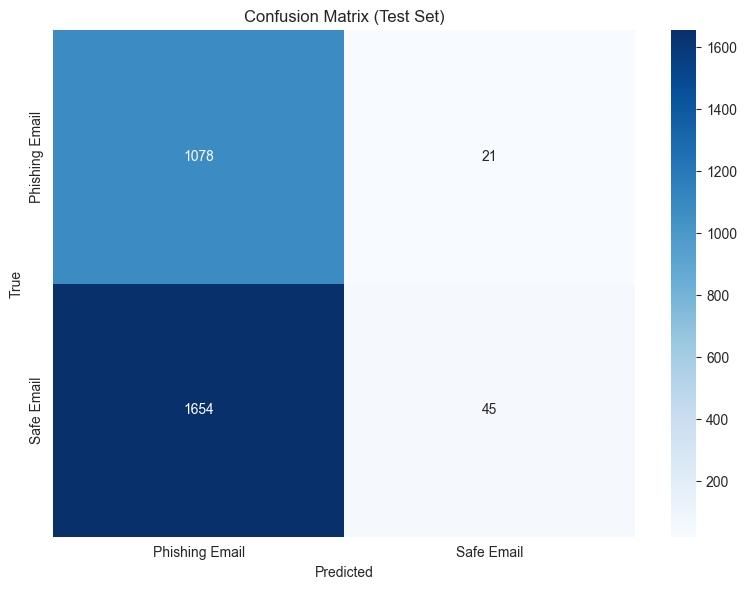

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()